# Forecast the Airlines Passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing double
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

In [143]:
data=pd.read_excel("Airlines+Data.xlsx")
data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# EDA

In [144]:
data.shape

(96, 2)

<Axes: >

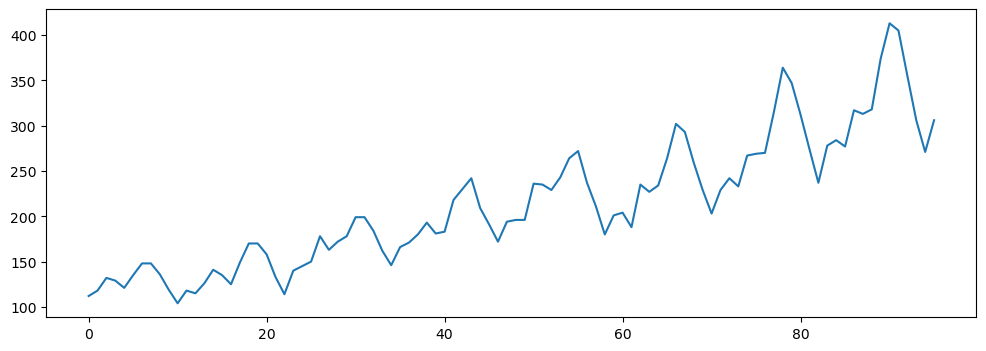

In [145]:
plt.figure(figsize=(12,4))
data.Passengers.plot()

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [147]:
data.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [148]:
data[data.duplicated()]

,Month,Passengers


In [149]:
data["Date"] = pd.to_datetime(data.Month,format="%b-%y")
data["month"] = data.Date.dt.strftime("%b") # month extraction
data["year"] = data.Date.dt.strftime("%Y") # year extraction
data

,Month,Passengers,Date,month,year
0,1995-01-01,112,1995-01-01,Jan,1995
1,1995-02-01,118,1995-02-01,Feb,1995
2,1995-03-01,132,1995-03-01,Mar,1995
3,1995-04-01,129,1995-04-01,Apr,1995
4,1995-05-01,121,1995-05-01,May,1995
...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,Aug,2002
92,2002-09-01,355,2002-09-01,Sep,2002
93,2002-10-01,306,2002-10-01,Oct,2002
94,2002-11-01,271,2002-11-01,Nov,2002


<Axes: xlabel='month', ylabel='year'>

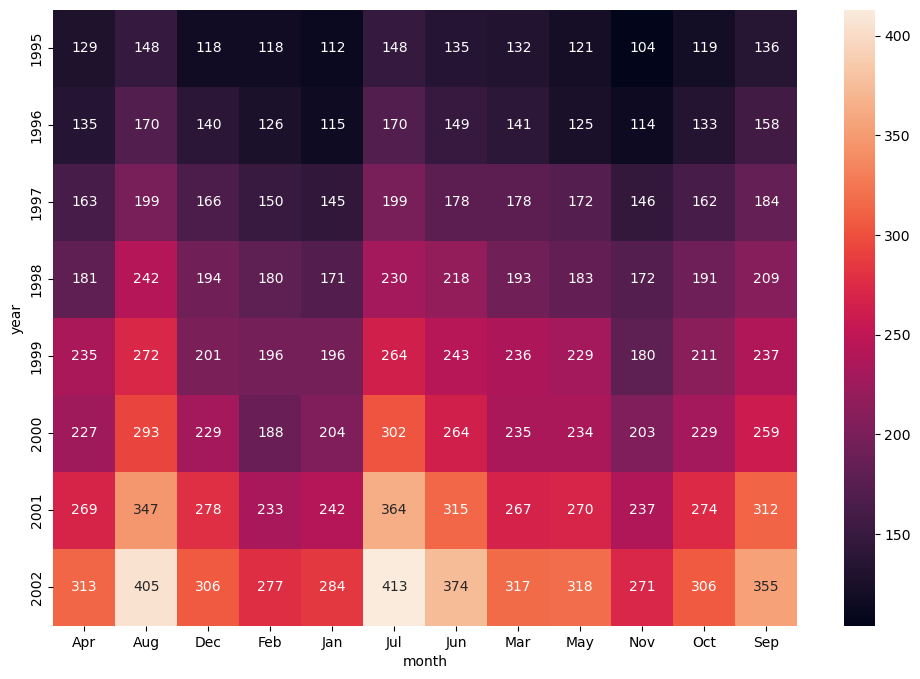

In [150]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

<Axes: xlabel='year', ylabel='Passengers'>

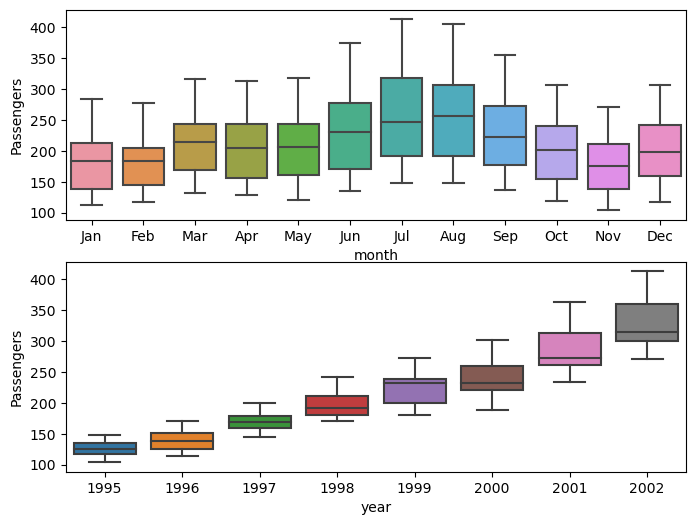

In [151]:
# Boxplot

plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=data)

In [152]:
data1=pd.get_dummies(data,columns=['month'],dtype=int)
data1.head()

,Month,Passengers,Date,year,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1995-01-01,112,1995-01-01,1995,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,1995-02-01,1995,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995-03-01,1995,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,1995-04-01,1995,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995-05-01,1995,0,0,0,0,0,0,0,0,1,0,0,0


# Splitting data

In [155]:
Train = data1.head(84)
Test = data1.tail(12)

# Moving Average

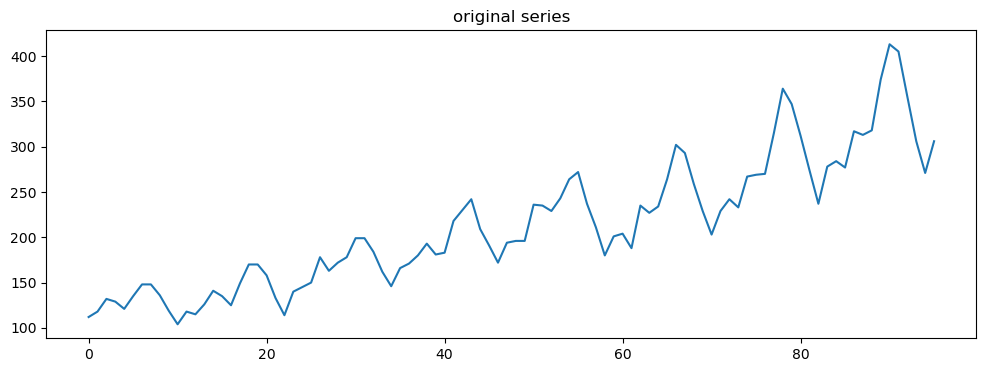

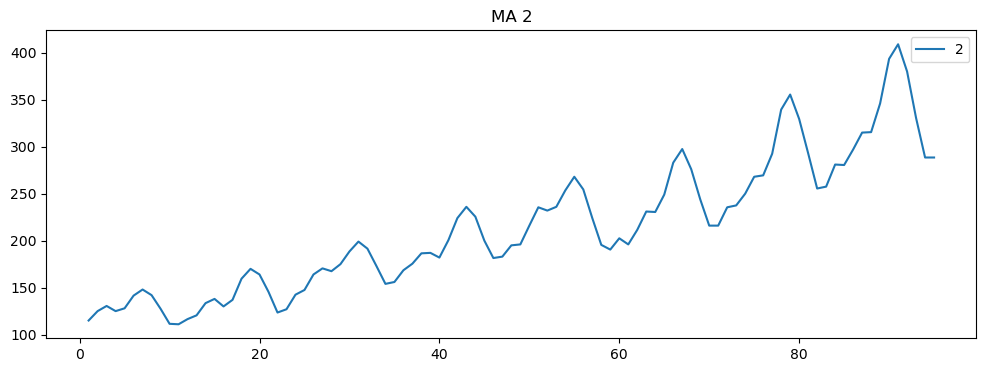

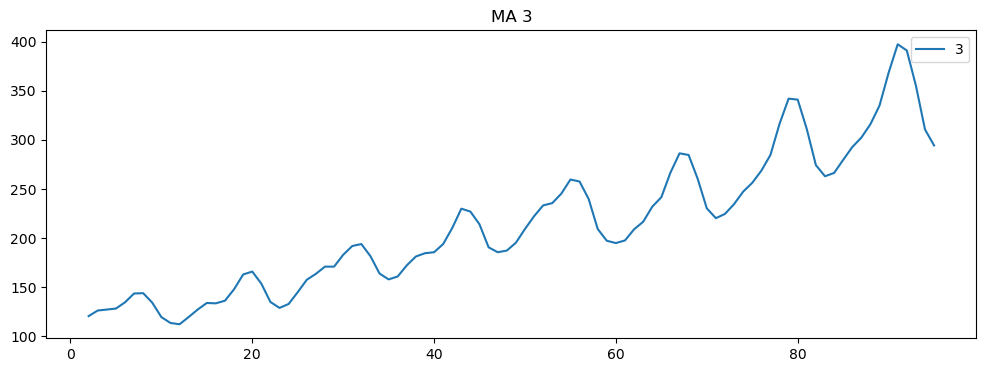

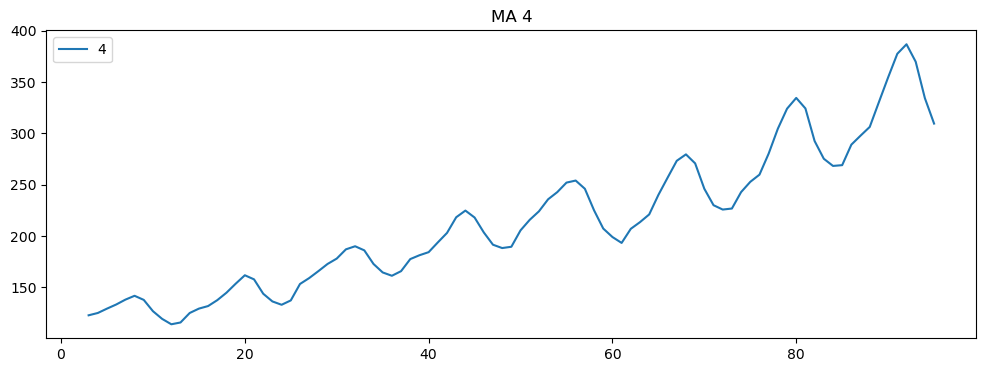

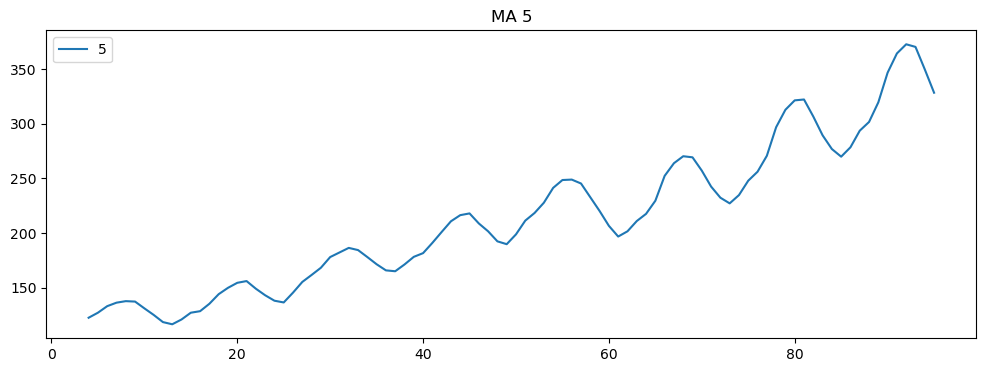

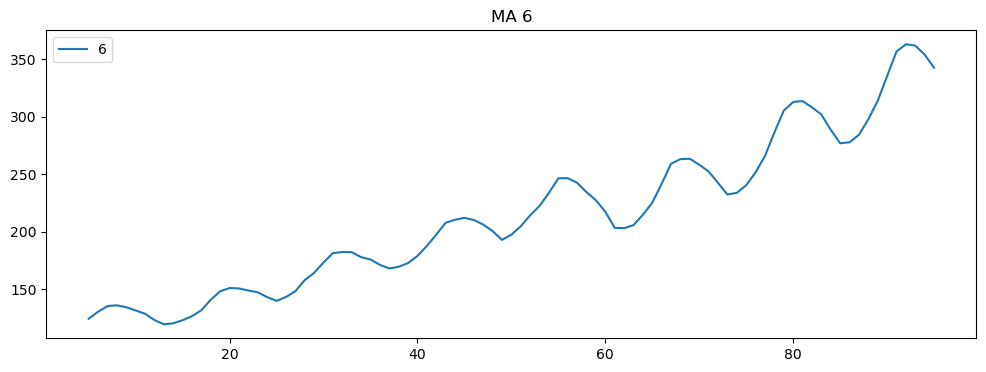

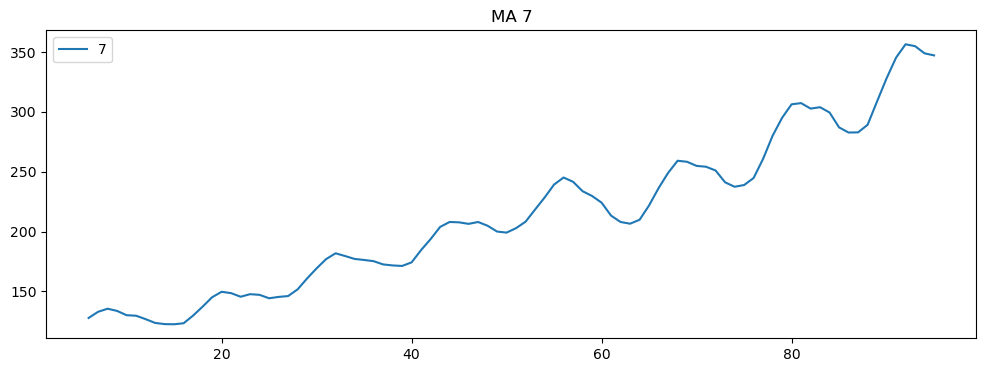

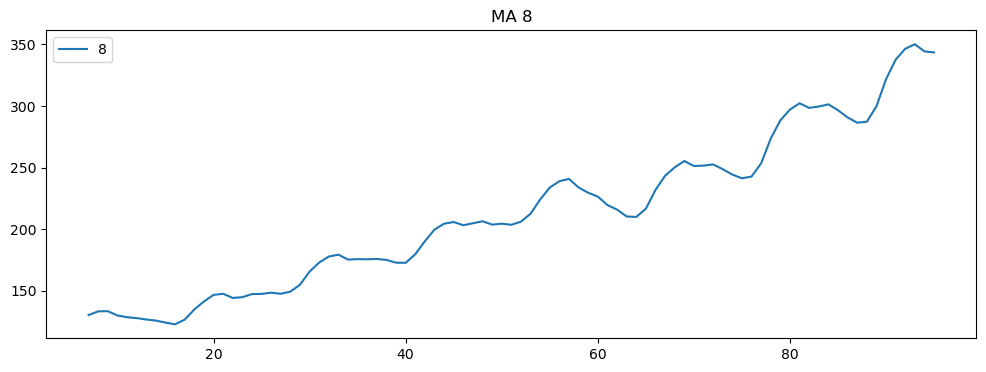

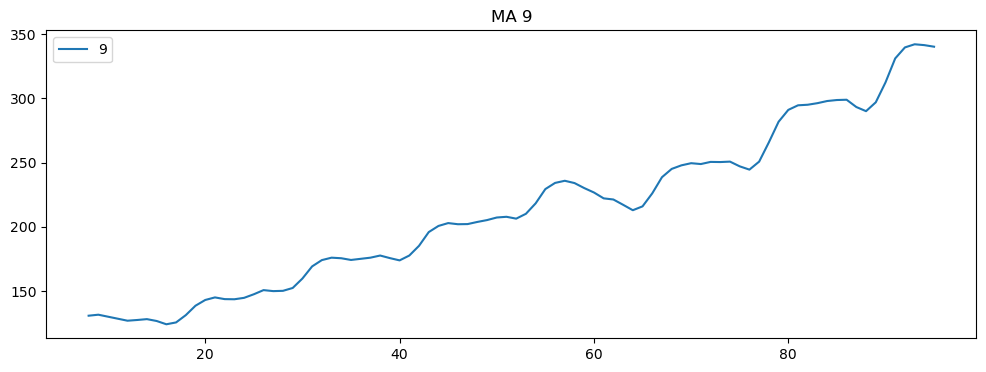

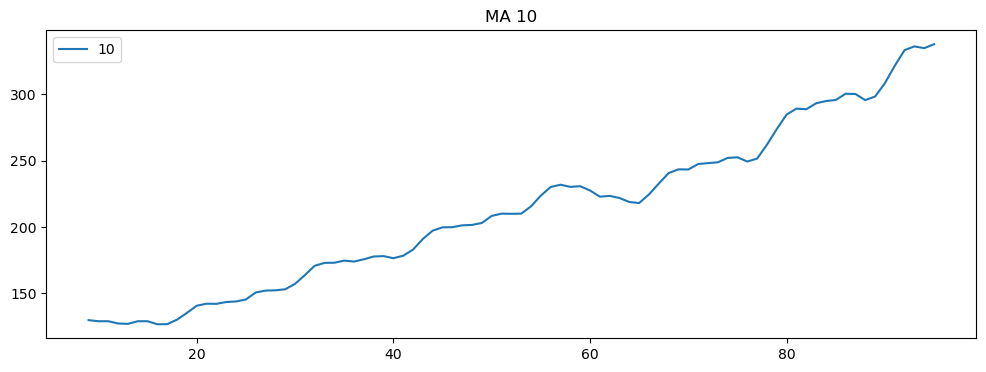

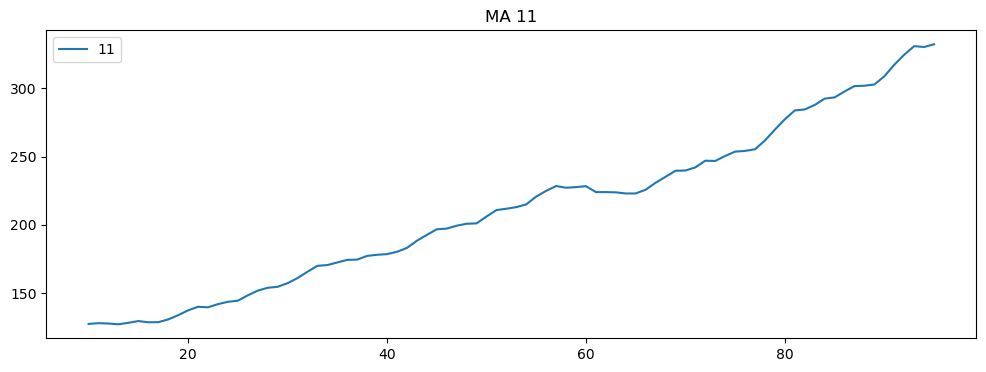

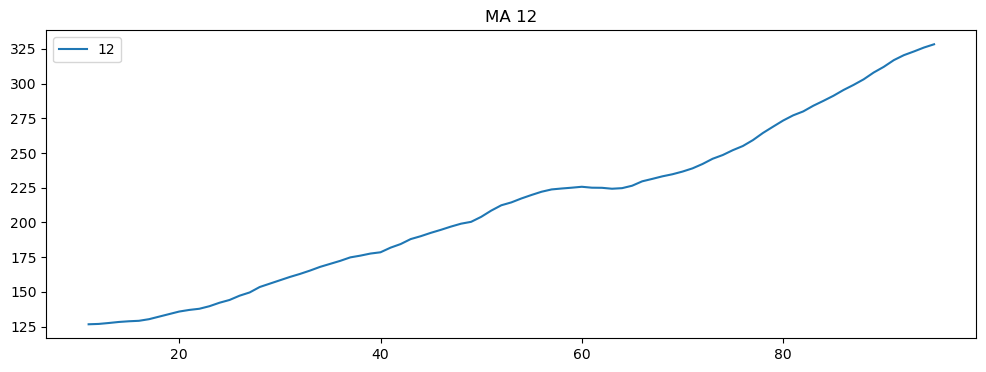

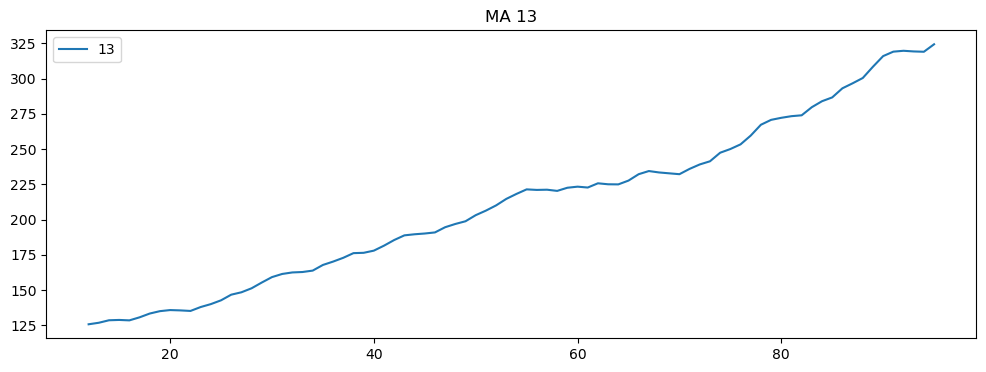

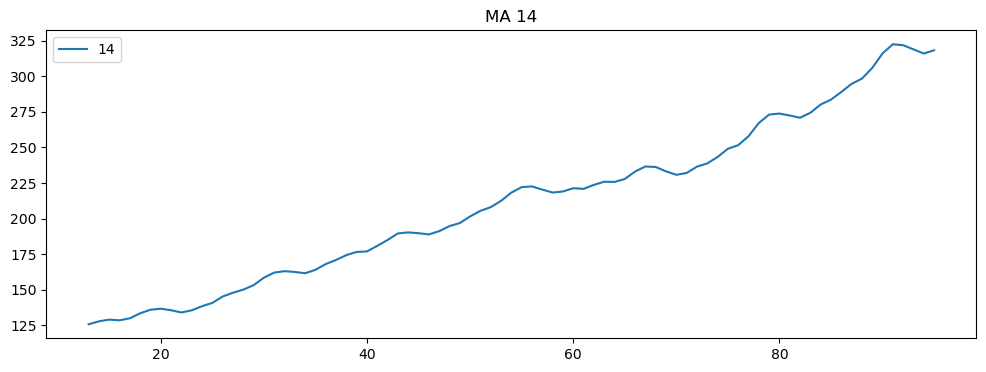

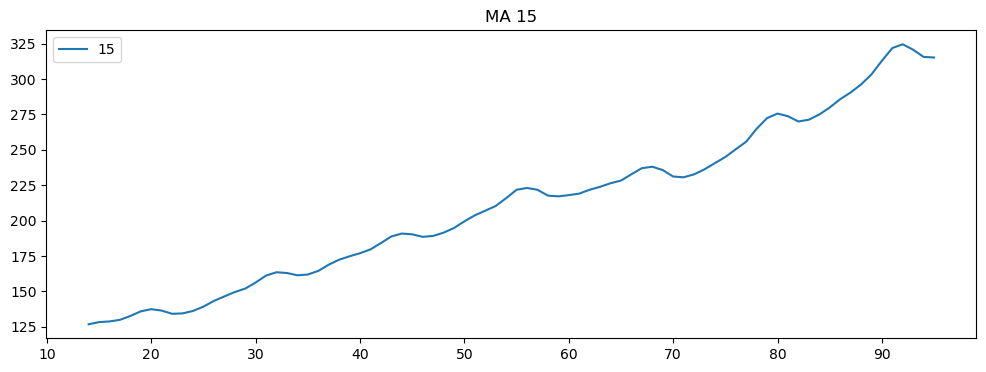

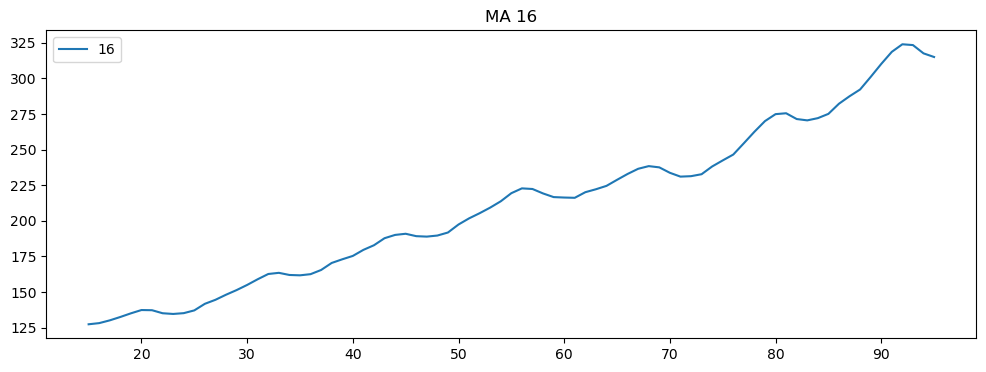

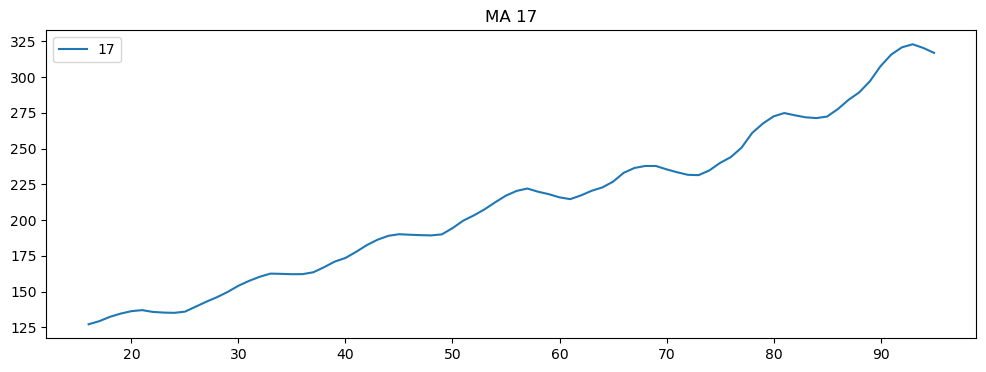

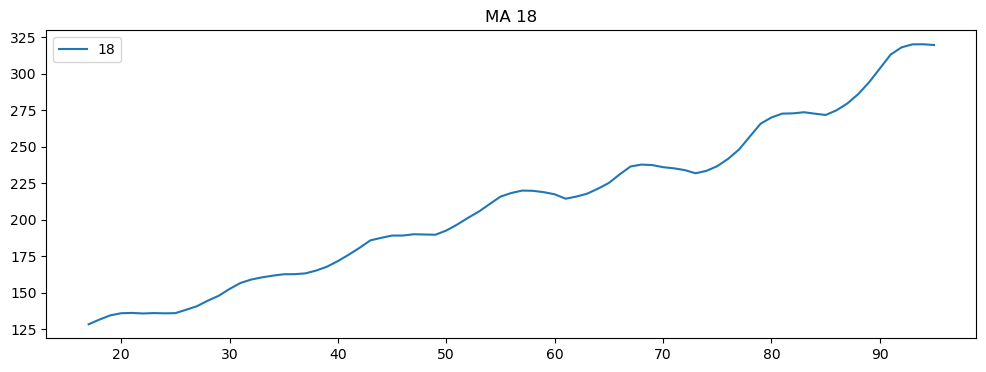

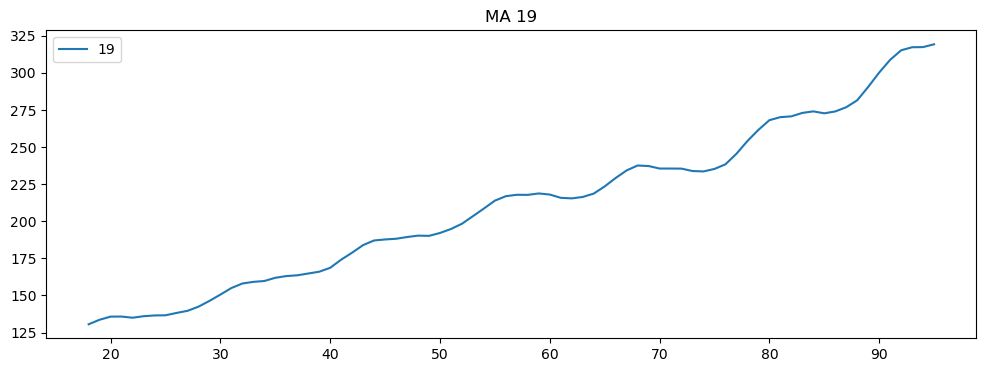

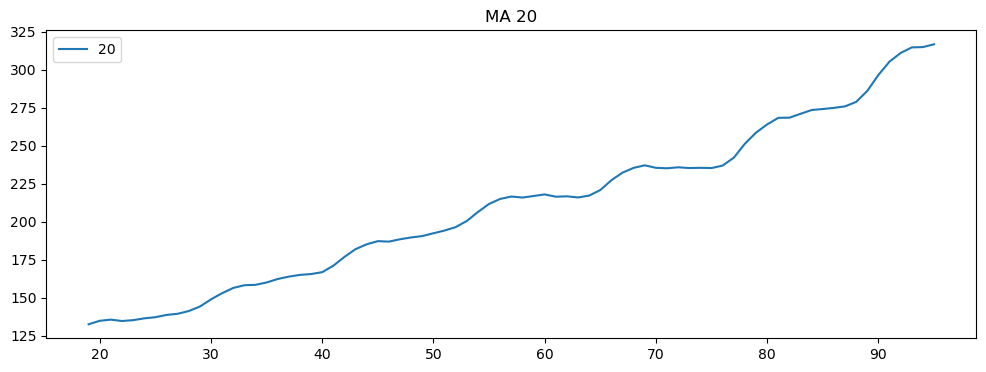

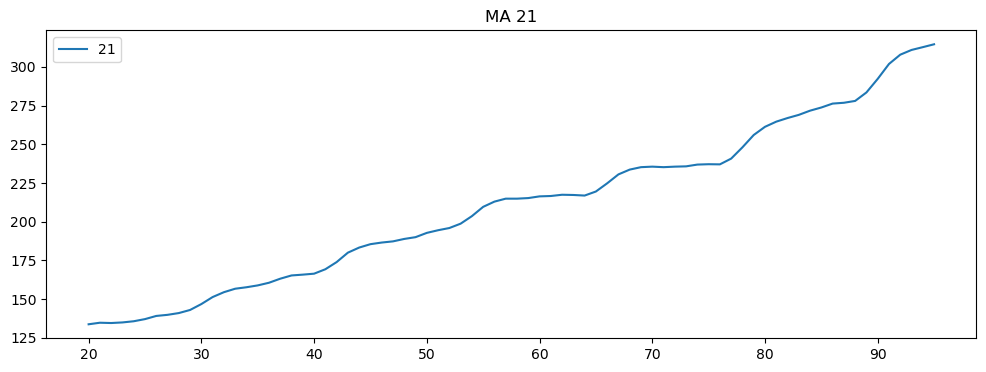

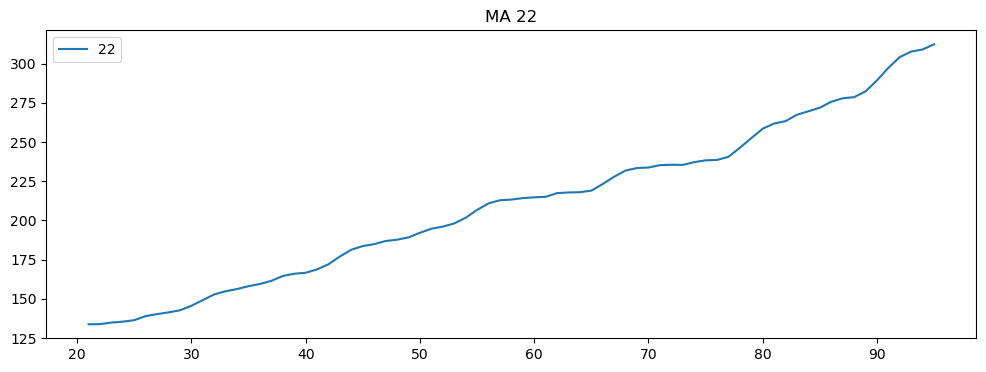

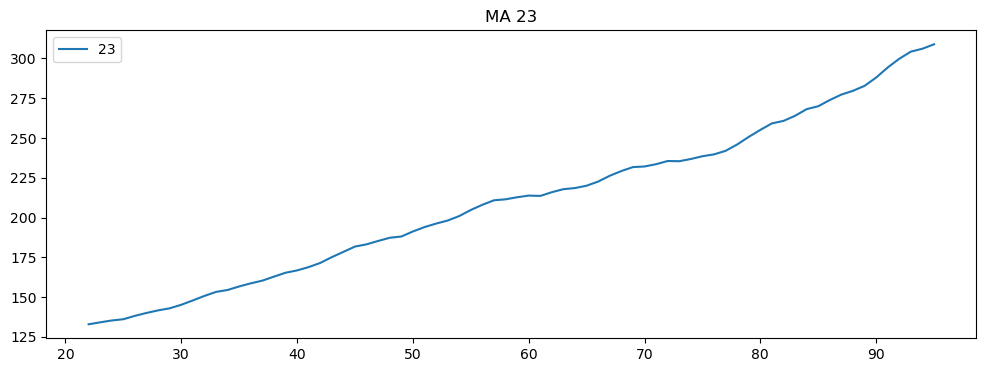

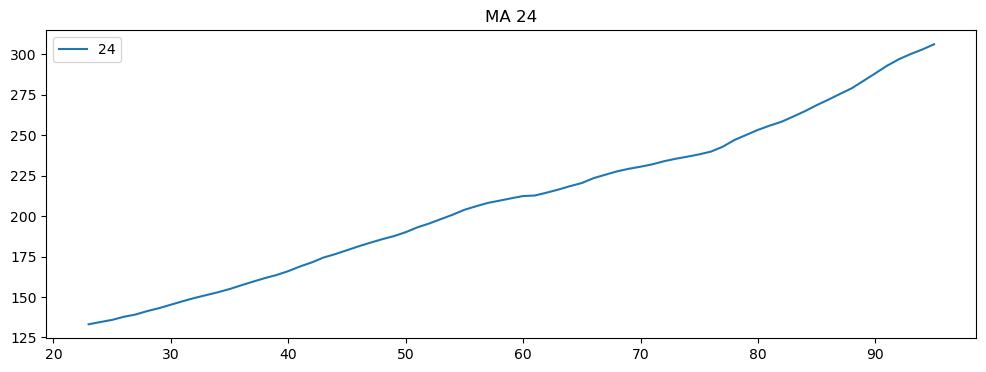

In [156]:
plt.figure(figsize=(12,4))
data1.Passengers.plot(label="org")
plt.title("original series")

for i in range(2,25):
    plt.figure(figsize=(12,4))


    data1["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("MA "+str(i))
    plt.legend(loc='best')
    plt.show()

# Time series decomposition plot

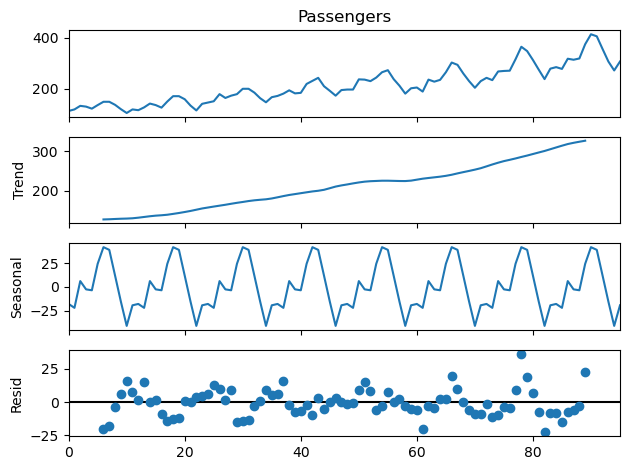

In [157]:
decompose_ts_add = seasonal_decompose(data1.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

# Evaluation Metric MAPE

In [168]:
def MAPE(org,pred):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple Exponential Method

In [174]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.9)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE_ses=MAPE(Test.Passengers,pred_ses)
MAPE_ses

15.092823851087173

# Double Exponential Method

In [175]:
de_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_de = de_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE_de=MAPE(pred_de,Test.Passengers)
MAPE_de

33.78833135535859

# Holts winter exponential smoothing with additive seasonality and additive trend

In [176]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE_hw=MAPE(pred_hwe_add_add,Test.Passengers)
MAPE_hw

6.381142886671835

# Final Model by combining train and test

In [180]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()

In [181]:
data = {"MODEL":pd.Series(["MAPE_ses","MAPE_de","MAPE_hw"]),"MAPE_Values":pd.Series([MAPE_ses,MAPE_de,MAPE_hw])}
table_MAPE=pd.DataFrame(data)
table_MAPE.sort_values(['MAPE_Values'])

,MODEL,MAPE_Values
2,MAPE_hw,6.381143
0,MAPE_ses,15.092824
1,MAPE_de,33.788331


In [182]:
#Forecasting for next 10 time periods

hwe_model_add_add.forecast(10)

84    280.944396
85    281.798447
86    309.077403
87    302.931846
88    302.229774
89    326.227545
90    351.233869
91    350.368854
92    325.228423
93    300.079643
dtype: float64